# Unsupervised Anomaly Detection

Anomaly detection detects data points in data that does not fit well with the rest of data. In this notebook we demonstrate how to do anomaly detection for 1-D data using Chronos's dbscan detector, autoencoder detector and threshold detector.

For demonstration, we use the publicly available cluster trace data cluster-trace-v2018 of Alibaba Open Cluster Trace Program. You can find the dataset introduction <a href="https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md" target="_blank">here</a>. In particular, we use machine usage data to demonstrate anomaly detection, you can download the separate data file directly with <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>.

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def get_result_df(df, ano_index):
    """
    Add anomalies value to dataframe.
    """
    result_df = df.copy()
    result_df['anomalies'] = 0
    result_df.loc[df.index[ano_index], 'anomalies'] = 1
    result_df['anomalies'] = result_df['anomalies'] > 0
    return result_df

In [2]:
def plot_anomalies_value(date, y, anomalies):
    """
    plot the anomalies value
    """
    fig, axs = plt.subplots(figsize=(16,6))
    
    axs.plot(date, y, color='blue', label='y')
    axs.scatter(date[anomalies].tolist(), y[anomalies], color='red', label='anomalies value')
    axs.set_title('the anomalies value')
    
    plt.xlabel('datetime')
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe.Steps are as below:
* First, download the raw data <a href="http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz" target="_blank">machine_usage</a>. Or run the script `get_data.sh` to download the raw data.It will download the resource usage of each machine from m_1932 to m_2085. 
* Second, run `grep m_1932 machine_usage.csv > m_1932.csv` to extract records of machine 1932. Or run `extract_data.sh`.We use machine 1932 as an example in this notebook.You can choose any machines in the similar way.
* Finally, use pandas to load `m_1932.csv` into a dataframe as shown below.

In [19]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
df_1932 = pd.read_csv("m_1932.csv", header=None, usecols=[1,2,3], names=["time_step", "cpu_usage","mem_usage"])

Below are some example records of the data

In [21]:
df_1932.head()

,time_step,cpu_usage,mem_usage
0,386640,41,92
1,386670,43,92
2,386690,44,92
3,386800,46,92
4,386930,44,93


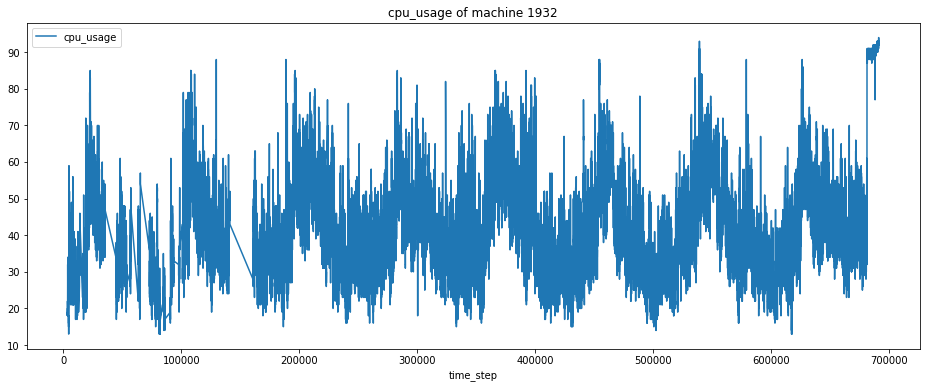

In [22]:
df_1932.sort_values(by="time_step", inplace=True)
df_1932.reset_index(inplace=True)
df_1932.plot(y="cpu_usage", x="time_step", figsize=(16,6),title="cpu_usage of machine 1932")

## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the machine_usage data, the pre-processing contains 2 parts:
1. Convert the time step in seconds to timestamp starting from 2018-01-01
2. Generate a built-in TSDataset to resample the average of cpu_usage in minutes and impute missing data

In [23]:
df_1932["time_step"] = pd.to_datetime(df_1932["time_step"], unit='s', origin=pd.Timestamp('2018-01-01'))

In [29]:
from zoo.chronos.data import TSDataset

tsdata = TSDataset.from_pandas(df_1932, dt_col="time_step", target_col="cpu_usage")
df = tsdata.resample(interval='1min', start_time=tsdata.df['time_step'].iloc[0],  end_time=tsdata.df['time_step'].iloc[-1], merge_mode="mean")\
           .impute(mode="last")\
           .to_pandas()

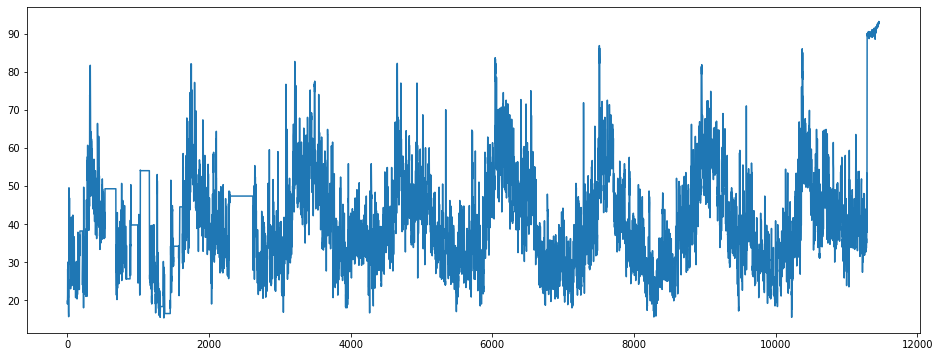

In [25]:
df['cpu_usage'].plot(figsize=(16,6))

## Anomaly Detection by DBScan Detector

DBScanDetector uses DBSCAN clustering for anomaly detection. The DBSCAN algorithm tries to cluster the points and label the points that do not belong to any clusters as -1. It thus detects outliers detection in the input time series. DBScanDetector assigns anomaly score 1 to anomaly samples, and 0 to normal samples.

In [10]:
from zoo.chronos.model.anomaly import DBScanDetector

ad = DBScanDetector(eps=0.1, min_samples=6)
ad.fit(df['cpu_usage'].to_numpy())

In [11]:
anomaly_scores = ad.score()
anomaly_indexes = ad.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores are: [0. 0. 0. ... 1. 1. 1.]
The anomaly indexes are: [   15    16    17    18   315   316   317   318   319   320   321   322
   323   324   325   326  1246  1287  1296  1300  1301  1302  1305  1306
  1307  1308  1310  1311  1312  1362  1454  1687  1732  1742  1743  1744
  1745  1746  1747  1748  1749  1750  1751  1752  1753  1761  1762  1796
  1818  3050  3086  3087  3192  3209  3210  3211  3212  3213  3214  3215
  3216  3217  3218  3219  3226  3229  3279  3422  3429  3433  3434  3437
  3448  3487  3488  3489  3490  3491  3492  3493  3494  3495  3549  4268
  4652  4653  4654  4655  4656  4657  4658  4659  4660  4661  4675  4693
  4709  4784  4936  4937  4938  5341  5342  5493  6037  6039  6040  6041
  6042  6043  6044  6045  6046  6047  6048  6049  6057  6058  6059  6060
  6086  6103  6128  6148  6150  6151  6152  6156  6183  6184  6196  6211
  6212  6218  6223  6235  6245  6404  6405  6406  6408  6477  6544  6750
  7022  7136  7289  7448  7507  7508  7509  7510  7

Draw anomalies in line chart.

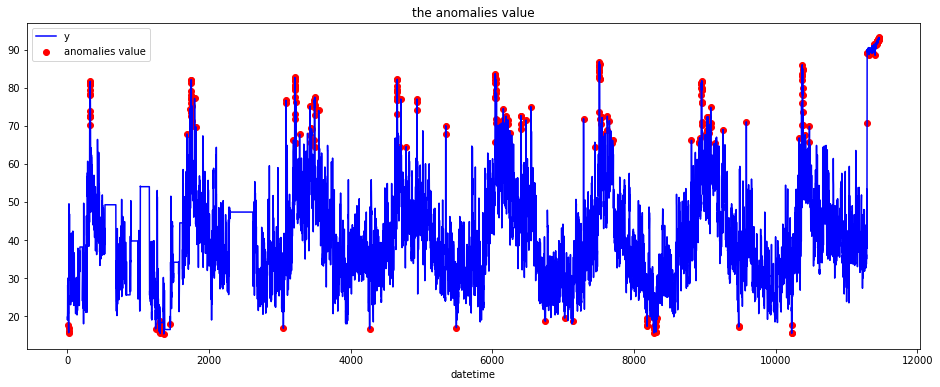

In [12]:
result_df = get_result_df(df, anomaly_indexes)
plot_anomalies_value(result_df.index, result_df.cpu_usage, result_df.anomalies)

## Anomaly Detection by AutoEncoder Detector

AEDetector is unsupervised anomaly detector. It builds an autoencoder network, try to fit the model to the input data, and calcuates the reconstruction error. The samples with larger reconstruction errors are more likely the anomalies.

In [13]:
from zoo.chronos.model.anomaly import AEDetector

ad = AEDetector(roll_len=10, ratio=0.05)
ad.fit(df['cpu_usage'].to_numpy())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
anomaly_scores = ad.score()
anomaly_indexes = ad.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores are: [0.5448079  0.5497363  0.53821826 ... 0.93018836 0.93016964 0.9292362 ]
The anomaly indexes are: [10027  9933  5502  4660  8257  9932  3946  8321  8301  4661  8193  1354
  3949  1749  7131  7136   324  4652  1750  8324  9475  1252  9985 10225
  9998  7135  3953  3956  8260  3936  8325  6752  7127   317  9986 11290
  8256  8295  8322    14  3947  3950  6740  8179  3951  1249  3952  1369
  8302  9994 10233  9989  8180  1242  8274  9996  8961  3945  3955  8252
  7125  1284  8290  9995  1358  1244  1281  1357  1370     9  9476  8323
  1247  8303  6751  9473  3209 10235  1248  1245  3217  7126  6749  9988
  9997  9990  1742  8291  7132  1285  1250  1359 11291  8960  8306  6748
  3957  1368  9992   322    11  3948  1251    10  6747  1243   318  1367
  1282  1364  8273  8191  6743  9991  9478 10228  8192  6742  1360  8318
  9477   323  1294  1283  9480    12  1361  6741  9993  8183  8181  6745
    19  6746  1366  1297  6744  1365 10227  6750  1745 10386  1371  3218
  4

Draw anomalies in line chart.

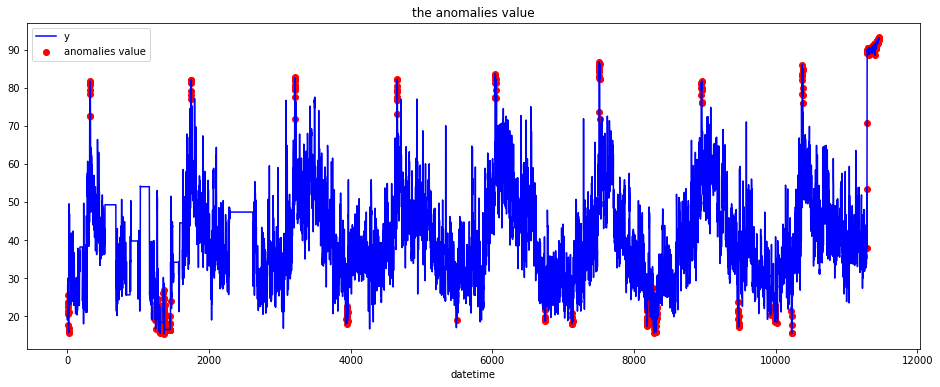

In [15]:
result_df = get_result_df(df, anomaly_indexes)
plot_anomalies_value(result_df.index, result_df.cpu_usage, result_df.anomalies)

## Anomaly Detection by Threshold Detector

ThresholdDetector is a simple anomaly detector that detectes anomalies based on threshold. The target value for anomaly testing can be either 1) the sample value itself or 2) the difference between the forecasted value and the actual value. In this notebook we demostrate the first type. The thresold can be set by user or esitmated from the train data accoring to anomaly ratio and statistical distributions.

In [16]:
from zoo.chronos.model.anomaly import ThresholdDetector

thd=ThresholdDetector()
thd.set_params(threshold=(20, 80))
thd.fit(df['cpu_usage'].to_numpy())

In [17]:
anomaly_scores = thd.score()
anomaly_indexes = thd.anomaly_indexes()

print("The anomaly scores are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores are: [1. 1. 0. ... 1. 1. 1.]
The anomaly indexes are: [0, 1, 15, 16, 17, 18, 8232, 8252, 8260, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8287, 8288, 8295, 8304, 8305, 8308, 8309, 8310, 8311, 8312, 8313, 8315, 8316, 8323, 8328, 10377, 10378, 8331, 10379, 10381, 10382, 10383, 4267, 4268, 4320, 228, 8187, 319, 320, 321, 323, 8563, 4657, 4658, 4659, 6741, 6742, 6743, 6744, 6745, 6746, 6750, 6828, 8951, 8952, 8953, 8958, 8959, 7022, 7066, 7072, 7516, 7517, 7116, 7125, 7126, 7127, 7132, 7135, 7136, 3050, 5492, 5493, 11293, 11294, 11295, 11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323, 11324, 11325, 11326, 11327, 11328, 11329, 11330, 11331, 11332, 11333, 11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341, 11342, 11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351, 11352, 11353, 11354, 11355, 11356,

Draw anomalies in line chart.

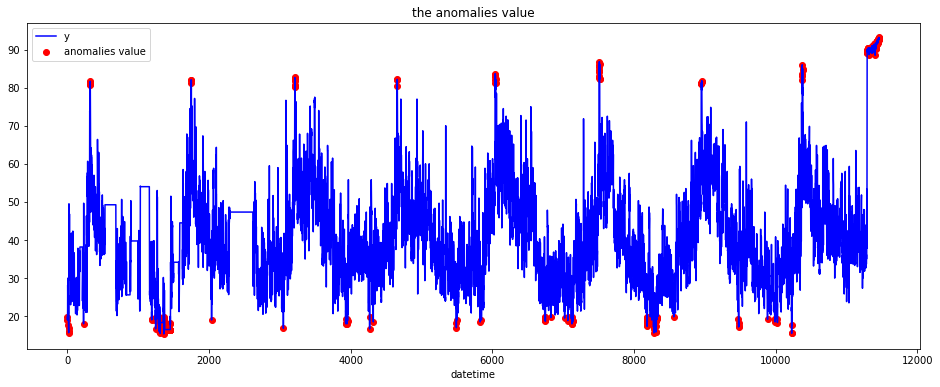

In [18]:
result_df = get_result_df(df, anomaly_indexes)
plot_anomalies_value(result_df.index, result_df.cpu_usage, result_df.anomalies)